In [4]:
%reset -f
import sys
# sys.path.append("/home/jose/Documents/Maestria/Codigo/OTI/build/")
# sys.path.append("/Users/maristi7/coding/otilib/build")
# sys.path.append("anterior/")
import Calc_Cable as cab
# import Calc_Cable_20201116 as cab_old
import pyoti.sparse as oti
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern Roman",
    "font.size": 12,
    "font.sans-serif": ["Helvetica"]
})

In [5]:
order = 2
nbases = 7
l,h,L0,A0,E,w,cargas = cab.leer_entradas("Irvine_1")
cargas = cargas.astype(object)
F = cargas[0][0]
F = F + oti.e(1,order=order)
cargas[0][0] = F
#convertir adimensionales
gamma,delta,beta,Psi,Sigmas = cab.param_adim(l,h,L0,A0,E,w,cargas)
#calcular las incognitas gi fi
gi_0, fi_0 = 0.275, 0.275 #valores iniciales para iterar en newton
gi,fi = cab.calc_gi_fi(order,nbases,gamma,delta,beta,Psi,Sigmas,gi_0,fi_0)

Error for iter 0 - 1.182292e+00
Current solution:
 [[0.275]
 [0.275]]
Error for iter 1 - 1.243495e-01
Current solution:
 [[0.34560139]
 [0.72935114]]
Error for iter 2 - 5.648969e-02
Current solution:
 [[0.42666056]
 [0.67017529]]
Error for iter 3 - 1.164553e-02
Current solution:
 [[0.47091845]
 [0.66273421]]
Error for iter 4 - 4.377901e-04
Current solution:
 [[0.48037076]
 [0.66219096]]
Error for iter 5 - 6.002641e-07
Current solution:
 [[0.48072872]
 [0.66217941]]
Error for iter 6 - 1.128863e-12
Current solution:
 [[0.48072921]
 [0.6621794 ]]
Error for iter 7 - 1.172526e-16
Current solution:
 [[0.48072921]
 [0.6621794 ]]


<IPython.core.display.Javascript object>


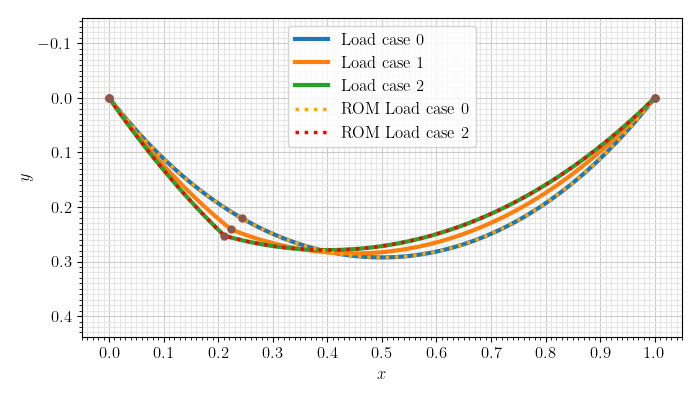

Error for iter 0 - 5.933663e-01
Current solution:
 [[0.275]
 [0.275]]
Error for iter 1 - 9.639366e-02
Current solution:
 [[0.30647785]
 [0.50360838]]
Error for iter 2 - 3.947109e-02
Current solution:
 [[0.3632018 ]
 [0.50018233]]
Error for iter 3 - 5.381746e-03
Current solution:
 [[0.38759984]
 [0.50000423]]
Error for iter 4 - 8.985672e-05
Current solution:
 [[0.39100456]
 [0.50000001]]
Error for iter 5 - 2.464203e-08
Current solution:
 [[0.3910616]
 [0.5      ]]
Error for iter 6 - 1.969799e-15
Current solution:
 [[0.39106161]
 [0.5       ]]
Error for iter 7 - 0.000000e+00
Current solution:
 [[0.39106161]
 [0.5       ]]
Conf. 0: x = 0.24300198860068611 , y = 0.22035453896228327
Error for iter 0 - 1.182292e+00
Current solution:
 [[0.275]
 [0.275]]
Error for iter 1 - 1.243495e-01
Current solution:
 [[0.34560139]
 [0.72935114]]
Error for iter 2 - 5.648969e-02
Current solution:
 [[0.42666056]
 [0.67017529]]
Error for iter 3 - 1.164553e-02
Current solution:
 [[0.47091845]
 [0.66273421]]
Err

In [6]:
#SOLUCION PARA EL CABLE DEL PAPER IRVINE
order = 10
nbases = 7

plt.figure(figsize=(7,4))

Xsol = []
for u in range(3):
    #Lectura de datos de entrada
    l,h,L0,A0,E,w,cargas = cab.leer_entradas("Irvine_"+str(u))
    cargas = cargas.astype(object)
    F = cargas[0][0]
    
    #Pertubar parametros 
#     e1 = oti.e(1,nbases=nbases, order=order)
#     e2 = oti.e(2,nbases=nbases, order=order)
#     e3 = oti.e(3,nbases=nbases, order=order)
#     e4 = oti.e(4,nbases=nbases, order=order)
#     e5 = oti.e(5,nbases=nbases, order=order)
#     e6 = oti.e(6,nbases=nbases, order=order)
    e7 = oti.e(7,nbases=nbases, order=order)
#     l = l + e1
#     h = h + e2
#     L0 = L0 + e3
#     A0 = A0 + e4
#     E = E + e5
#     w = w + e6
    F = F + e7
    cargas[0][0] = F

    #convertir adimensionales
    gamma,delta,beta,Psi,Sigmas = cab.param_adim(l,h,L0,A0,E,w,cargas)

    #calcular las incognitas gi fi
    gi_0, fi_0 = 0.275, 0.275 #valores iniciales para iterar en newton
    gi,fi = cab.calc_gi_fi(order,nbases,gamma,delta,beta,Psi,Sigmas,gi_0,fi_0)
    #print(gi.real*w.real*L0.real,fi.real*w.real*L0.real)
    
    #calcular curva
    p = 100 #puntos de la curva
    A = cab.curva(nbases,order,gi,fi,beta,Psi,Sigmas,p)

    #Convertir a dimensionales    
    x = (A[:,0]*L0).get_deriv(0)
    y = (A[:,1]*L0).get_deriv(0)
    T = (A[:,2]*w*L0).get_deriv(0)
    
    Xsol.append(A[:,:2]*L0)
    
    #Graficar cable
    if u==0 or u==1:
        cab.plot_curva(x,y,T,u,np.array([[None]]), [None], [None], [None] )
    
    else:
        cab.plot_curva(x,y,T,u,x_0,x_2,y_0,y_2)
        
    #Calculo de curvas por modelo de orden reducido
    if u==1:
        x_1 = A[:,0]*L0
        y_1 = A[:,1]*L0
        
        x_0 = x_1.rom_eval([7],[-9.8]).get_deriv(0)
        y_0 = y_1.rom_eval([7],[-9.8]).get_deriv(0)
        x_2 = x_1.rom_eval([7],[9.8]).get_deriv(0)
        y_2 = y_1.rom_eval([7],[9.8]).get_deriv(0)

        
        
        
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.01))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.01))

plt.grid(which='major', color=(0.8,0.8,0.8))
plt.grid(which='minor', color=(0.9,0.9,0.9))

plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

plt.axis('equal')

plt.legend()

plt.tight_layout()

plt.savefig("Irvine_oti.pdf")

<IPython.core.display.Javascript object>


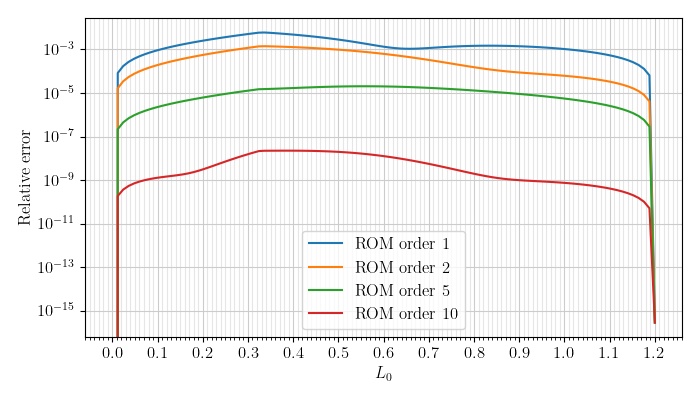


Order: 1
 0.0216936 - 9.20971e-05 * e([7])

Order: 2
 0.0216936 - 9.20971e-05 * e([7]) + 2.03162e-06 * e([[7,2]])

Order: 5
 0.0216936 - 9.20971e-05 * e([7]) + 2.03162e-06 * e([[7,2]]) - 3.80604e-08 * e([[7,3]]) + 7.24528e-10 * e([[7,4]]) - 1.58002e-11 * e([[7,5]])

Order: 10
 0.0216936 - 9.20971e-05 * e([7]) + 2.03162e-06 * e([[7,2]]) - 3.80604e-08 * e([[7,3]]) + 7.24528e-10 * e([[7,4]]) - 1.58002e-11 * e([[7,5]]) + 4.00178e-13 * e([[7,6]]) - 1.09329e-14 * e([[7,7]]) + 2.96597e-16 * e([[7,8]]) - 7.48456e-18 * e([[7,9]]) + 1.63076e-19 * e([[7,10]])


In [7]:

plt.figure(figsize=(7,4))

# Error
rom = Xsol[1]
exac= Xsol[0]

for ordi in [1,2,5,10]:
    
    rom_eval = rom.truncate_order(ordi)
    
    print("\nOrder: {0}".format(ordi))
    print(rom_eval[3,0])

    p_rom = rom_eval.rom_eval([7],[-9.8]).real

    p_exac = exac.real

    err = np.linalg.norm(p_rom-p_exac,axis=1)/L0.real

    plt.semilogy(L0.real*np.linspace(0,1,p+1),err,label='ROM order '+str(ordi))

# end for 

ax = plt.gca()

ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.01))

plt.grid(which='major', color=(0.8,0.8,0.8))
plt.grid(which='minor', color=(0.9,0.9,0.9))

plt.xlabel(r'$L_0$')
plt.ylabel(r'Relative error')

plt.legend()

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


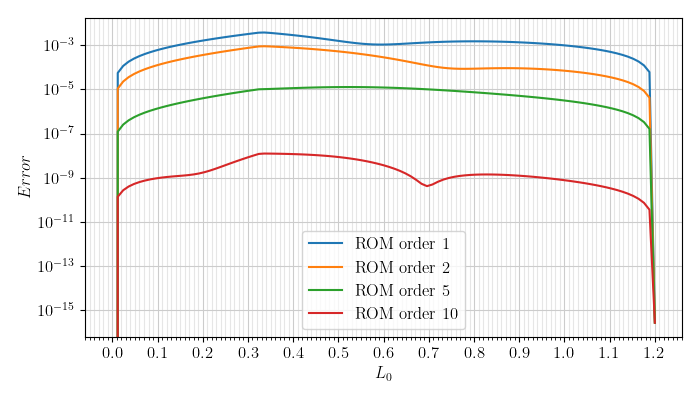


Order: 1
 0.0216936 - 9.20971e-05 * e([7])

Order: 2
 0.0216936 - 9.20971e-05 * e([7]) + 2.03162e-06 * e([[7,2]])

Order: 5
 0.0216936 - 9.20971e-05 * e([7]) + 2.03162e-06 * e([[7,2]]) - 3.80604e-08 * e([[7,3]]) + 7.24528e-10 * e([[7,4]]) - 1.58002e-11 * e([[7,5]])

Order: 10
 0.0216936 - 9.20971e-05 * e([7]) + 2.03162e-06 * e([[7,2]]) - 3.80604e-08 * e([[7,3]]) + 7.24528e-10 * e([[7,4]]) - 1.58002e-11 * e([[7,5]]) + 4.00178e-13 * e([[7,6]]) - 1.09329e-14 * e([[7,7]]) + 2.96597e-16 * e([[7,8]]) - 7.48456e-18 * e([[7,9]]) + 1.63076e-19 * e([[7,10]])


In [4]:

plt.figure(figsize=(7,4))

# Error
rom = Xsol[1]
exac= Xsol[2]

for ordi in [1,2,5,10]:
    
    rom_eval = rom.truncate_order(ordi)
    
    print("\nOrder: {0}".format(ordi))
    print(rom_eval[3,0])

    p_rom = rom_eval.rom_eval([7],[9.8]).real

    p_exac = exac.real

    err = np.linalg.norm(p_rom-p_exac,axis=1)/L0.real

    plt.semilogy(L0.real*np.linspace(0,1,p+1),err,label='ROM order '+str(ordi))

# end for 

ax = plt.gca()

ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.01))

plt.grid(which='major', color=(0.8,0.8,0.8))
plt.grid(which='minor', color=(0.9,0.9,0.9))

plt.xlabel(r'$L_0$')
plt.ylabel(r'$Error$')

plt.legend()

plt.tight_layout()
plt.show()

In [6]:
#SOLUCION PARA EL CABLE DEL PAPER IRVINE
order = 2
nbases = 6

for u in range(3):
    #Lectura de datos de entrada
    l,h,L0,A0,E,w,cargas = cab_old.leer_entradas("Irvine_"+str(u))
    
    #Pertubar parametros (no sirve para perturbar cargas y ubicacion s de las cargas)
    e1 = oti.e(1,nbases=nbases, order=order)
    e2 = oti.e(2,nbases=nbases, order=order)
    e3 = oti.e(3,nbases=nbases, order=order)
    e4 = oti.e(4,nbases=nbases, order=order)
    e5 = oti.e(5,nbases=nbases, order=order)
    e6 = oti.e(6,nbases=nbases, order=order)
    l = l + e1
    h = h + e2
    L0 = L0 + e3
    A0 = A0 + e4
    E = E + e5
    w = w + e6

    #convertir adimensionales
    gamma,delta,beta,Psi,Sigmas = cab_old.param_adim(l,h,L0,A0,E,w,cargas)

    #calcular las incognitas gi fi
    gi_0, fi_0 = 0.275, 0.275 #valores iniciales para iterar en newton
    gi,fi = cab_old.calc_gi_fi(order,nbases,gamma,delta,beta,Psi,Sigmas,gi_0,fi_0)

    #calcular curva
    p = 100 #puntos de la curva
    A = cab_old.curva(nbases,order,gi,fi,beta,Psi,Sigmas,p)

    #Convertir a dimensionales    
    x = (A[:,0]*L0).get_deriv(0)
    y = (A[:,1]*L0).get_deriv(0)
    T = (A[:,2]*w*L0).get_deriv(0)

    #Graficar cable
    cab_old.plot_curva(x,y,T,u)

NameError: name 'cab_old' is not defined